Данный ноутбук посвящён построению предсказательных моделей. Обзор данных - в ноутбуке ```data-preparation```.  Постановка задачи - в файле ```BST_Задача_Моделирование_вкладов.docx```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

- Данные для обучения: наблюдения признаков в 2011-2017г. включительно (```df```).
- Данные для проверки: наблюдения признаков за 2018г(```df_m-df```).

In [2]:
df = pd.read_csv('../data/BST_DataSet.csv', encoding='utf-8')

In [155]:
df_m = pd.read_csv('../data/BST_DataSet+mine1.csv', encoding='utf-8')

In [156]:
df_m.shape

(96, 12)

Настроим индекс по датам наблюдения

In [5]:
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.index = df.date
del(df['date'])

In [158]:
df_m.date = pd.to_datetime(df_m.date, format='%m/%d/%Y')
df_m.index = df_m.date
del(df_m['date'])

In [159]:
df_m.shape

(96, 11)

Посмотрим на данные в нормированном виде. По некоторым наблюдениям отличимы тренды, периоды (об этом позже),  заметен аномальный интервал в окрестности января 2015г.:

In [17]:
def normalizeData(df, plot=False):
    df_n = df.copy()
    for i in df_n.columns:
        m = max(df_n[i])
        df_n[i] = df_n[i].map(lambda x: x/m)
        if plot:
            plt.plot(df_n[i],label=i)
    return df_n

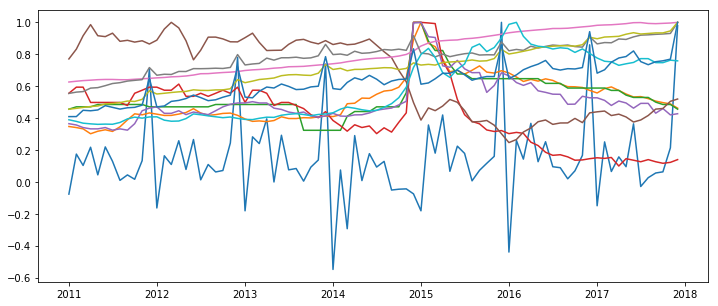

In [19]:
## plot normalized column values
plt.figure(figsize=(12,5))
df_n = normalizeData(df, plot=True)


Обратим внимание, что значения целевой переменной имеют сезонный характер. Построим ежегодные графики:

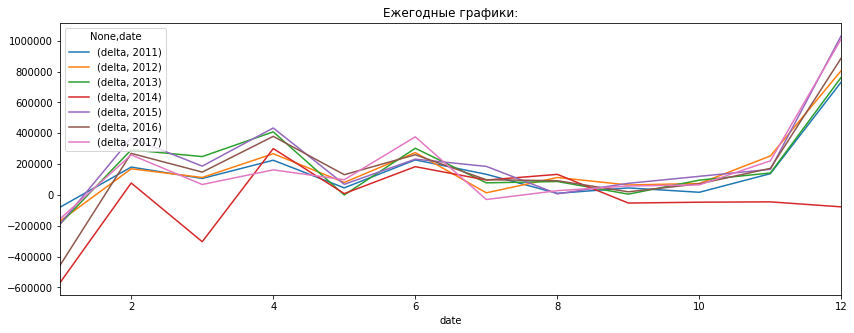

In [20]:
## plot year-long stats
pv = pd.pivot_table(df, index=df.index.month, columns=df.index.year,values=['delta'])
pv.plot(figsize=(14,5), title='Ежегодные графики:')

Построим матрицу попарных корреляций признаков, поскольку мы имеем подозрение на рыночную взаимосвязь некоторых из них. В частности, подозрение падает на пары ```денежная масса-зарплата```, ```инфляция-зарплата``` (в нашем случае ```ИПЦ``` - показатель инфляции).

Предположим интуитивно, что при повышении объёма денежной массы (например, при эмиссии денег) деньги при прочих равных обесцениваются, товары и услуги становятся дороже в денежном выражении, а соответственно, растут и зарплаты, складывающиеся из платы за эти услуги.  

На "карте температур" также заметно влияние цены на нефть и курса доллара 

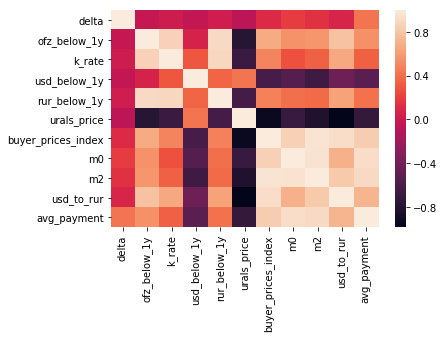

In [21]:
sns.heatmap(df.corr())

Построим диаграммы рассеяния признаков

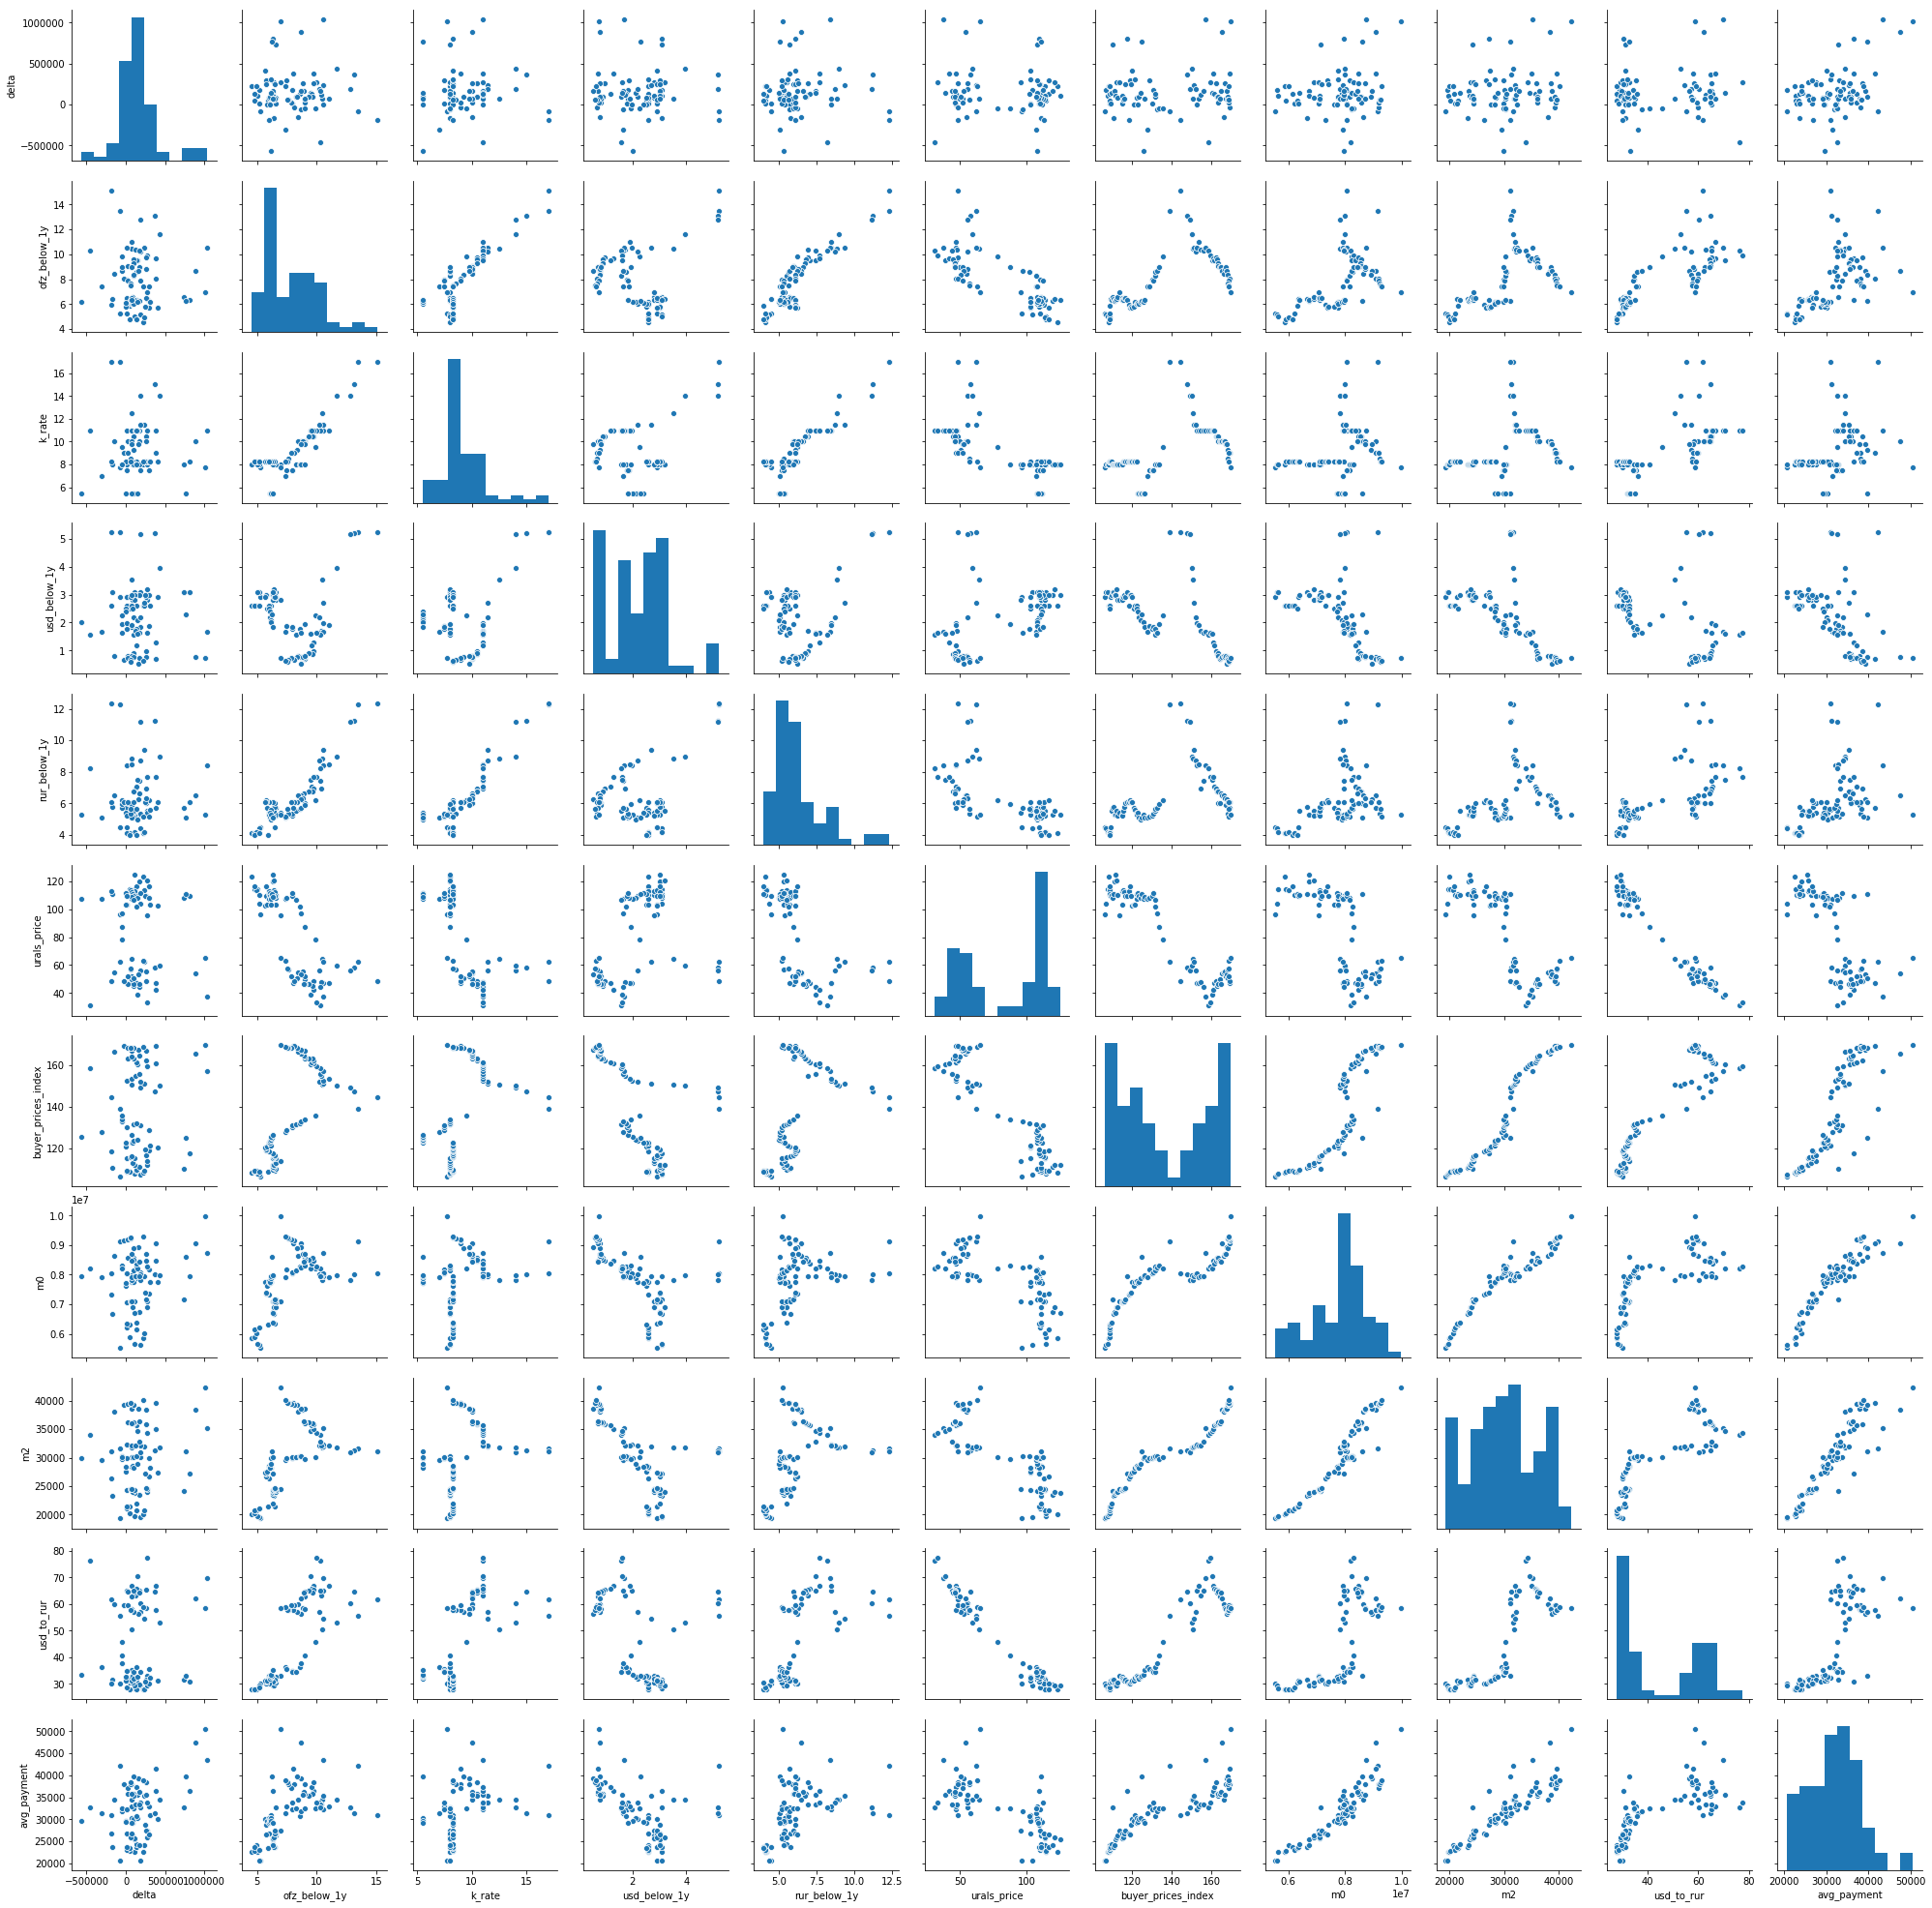

In [22]:
sns.pairplot(data=df)

Выделим те признаки, на которые у нас есть подозрение в линейной зависимости. Некоторые пары имеют около-кубическую зависимость на вид.

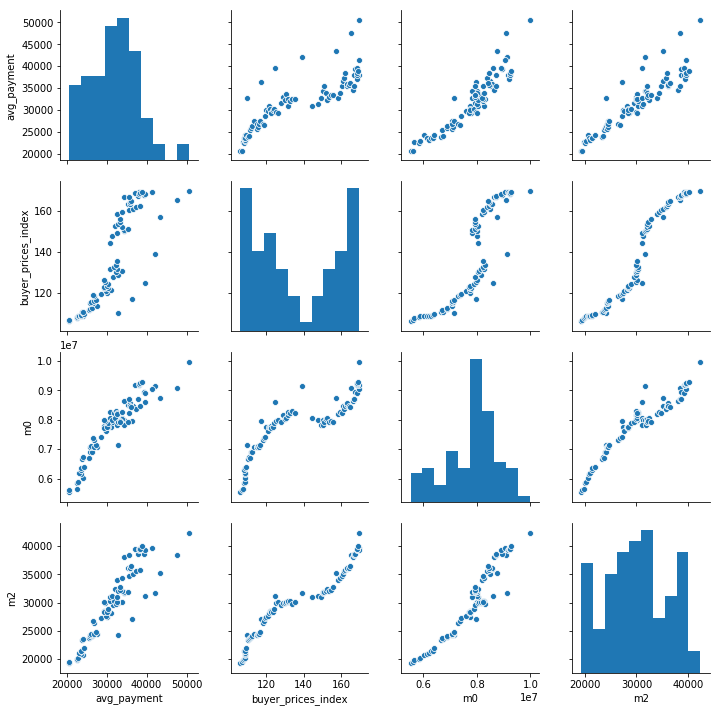

In [23]:
sns.pairplot(data=df[['avg_payment', 'buyer_prices_index','m0', 'm2']])

Так как условие задачи требует от нас интерпретируемости результатов, и количество наблюдений относительно невелико, то попробуем использовать в качестве предсказательной модели линейную регрессию.

Попробуем вначале наивный подход "в лоб", взяв данные в практически неизменном виде, пропустив проверку необходимых условий для работы линейной регрессии.

### Test-train separation

In [287]:
#test size is in months specially for our task
def prepareData(df, target_col='y',  test_index=0):
    df1 = df.copy()
    #if we have separate test-train files/datasets, use this
    if test_index==0:
        X, y = df1.drop([target_col], axis=1), df1[target_col]
        return X, y
    
    X_train = df1[:test_index].drop([target_col], axis=1)
    y_train = df1[:test_index][target_col]
    X_test = df1[test_index:].drop([target_col], axis=1)
    y_test = df1[test_index:][target_col]
    
    del(df1)
    return X_train, X_test, y_train, y_test

### Modelling: Linear

In [32]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

Проверим нашу модель на предоставленных заказчиком данных, построив для примера прогноз в 2017г. (соответственно, последние 12 месяцев исходного датасета: ```test_index=-12```)

In [48]:
X_train_2017, X_test_2017, y_train_2017, y_test_2017 = prepareData(df, target_col='delta', test_index=-12)

In [49]:
def predict(X_train, X_test, y_train, y_test, plot=True):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    prediction = lr.predict(X_test)
    if plot:
        plt.figure(figsize=(15, 7))
        plt.plot(prediction, "r", label="prediction")
        plt.plot(y_test.values, label="actual")
        plt.legend(loc="best")
        plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test))))
        plt.grid(True);
    return lr, prediction

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 array([ -64271.25623353,  -38636.64047121,  167460.0919185 ,
         174072.94399175,  282447.6336353 ,  421956.98956187,
         135923.47231963,   73934.41346947,  187659.95000574,
         200701.96240478,  293109.49616179, 1109703.27073457]))

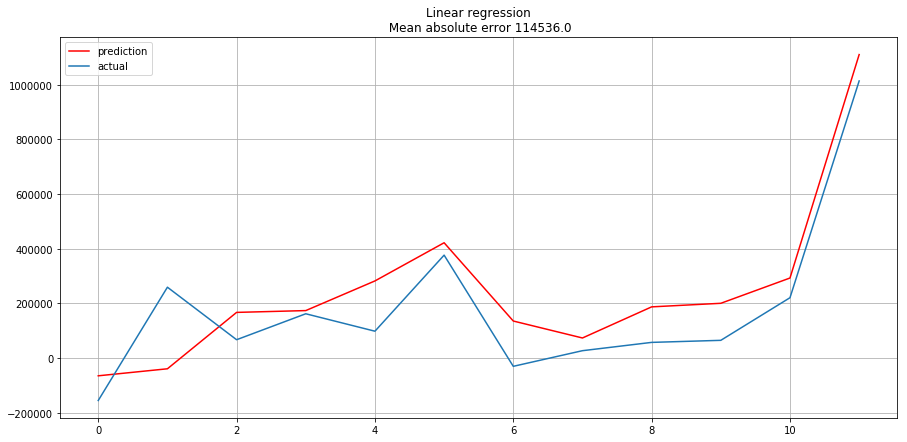

In [50]:
predict(X_train_2017, X_test_2017, y_train_2017, y_test_2017)

Видим, что выбранная предсказательная модель вполне годится для применения в первом приближении.

Обратимся к данным, включающим 2018 год:

In [160]:
X_train, X_test, y_train, y_test = prepareData(normalizeData(df_m), target_col='delta', test_index=-12)

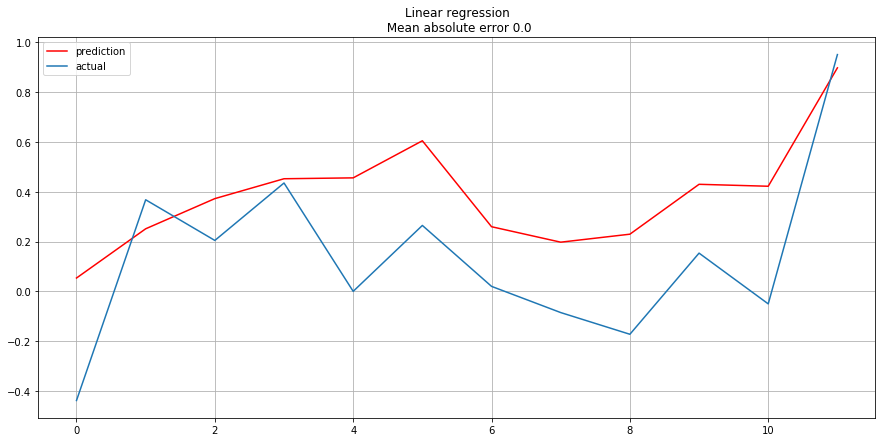

In [161]:
lr1, prediction1 = predict(X_train, X_test, y_train, y_test)

Как мы видим, при прогнозировании 2018г. на данных из открытых источников, которые "не бьются" с исходными (см. ноутбук ```data-preparation.ipynb```), получаем достаточно грубые результаты. "Garbage in - garbage out."

Посмотрим, какие параметры имеют наибольшее влияние на значение целевой переменной.

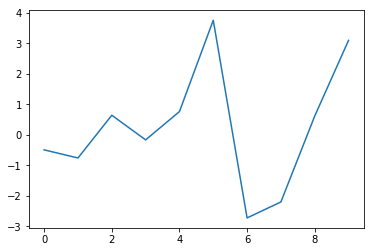

In [162]:
plt.plot(lr1.coef_)

Попробуем изменить поведение модели, избавившись от какого-то числа несущественных (или линейно зависимых друг от друга) признаков. Для этого воспользуемся методом главных компонент.

In [63]:
from sklearn.decomposition import PCA

In [179]:
def reduce(df, components=5):
    pca = PCA(components)
    XPCAreduced = pca.fit_transform(df)
    df_reduced = pd.DataFrame(XPCAreduced)
    return df_reduced

In [194]:
df_t = normalizeData(df_m)
df_t = df_t.drop(['delta'],axis=1)
df_reduced = reduce(df_t, 6)
del(df_t)

In [196]:
#sns.pairplot(df_reduced)

In [197]:
for i in df_reduced.columns:
    print(np.corrcoef(df_m['delta'],df_reduced[i])[0][1])

-0.08031085017300622
-0.004144170526861633
0.12325497298516967
0.059619085517765374
0.7624129523934142
0.1805478580442035


In [198]:
X_train = df_reduced[:-12]
X_test = df_reduced[-12:]
y_train = df_n['delta'][:-12]
y_test = df_n['delta'][-12:]

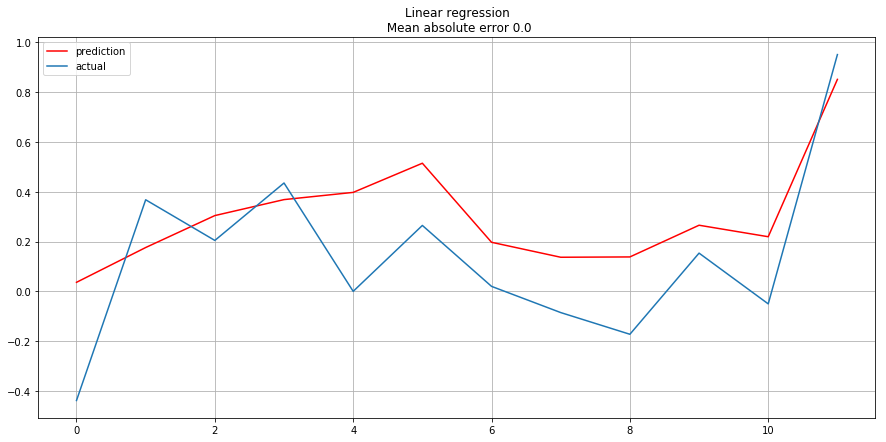

In [200]:
lr2, prediction2 = predict(X_train, X_test, y_train, y_test)

Для временных рядов полезны некоторые эвристики, например добавление признаков 'значение вчера', 'значение год назад'. Добавим их вместе с номером текущего месяца, года.

In [288]:
def addHeuristics(df, avg=False, previous_year=False, previous_month=False):
    df1 = df.copy()
    df1['month'] = df1.index.month
    df1['year'] = df1.index.year
    if previous_year:
        df1['previous_year_delta'] = df1['delta'].shift(12)
        df1 = df1[12:]
    if previous_month:
        df1['previous_month_delta'] = df1['delta'].shift(1)
        df1 = df1[1:]
    return df1

In [248]:
df_h = addHeuristics(df_m, previous_year=True)

In [249]:
df_h.shape

(84, 14)

In [250]:
X_train, X_test, y_train, y_test = prepareData(addHeuristics(normalizeData(df_m)), target_col='delta', test_index=-12)

In [251]:
lr3, prediction3 = predict(X_train, X_test, y_train, y_test, plot=False)

Посмотрим на коэффициенты, получившиеся при работе регрессии.

In [252]:
lr3.coef_

array([-0.89415139, -0.52744635,  0.6490504 , -0.22858396,  0.4563996 ,
       -0.9131501 , -3.92492992, -4.74442515,  0.78592661,  3.07205594,
        0.02723113,  0.47865707])

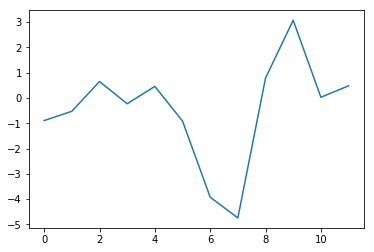

In [253]:
plt.plot(lr3.coef_)

Заметим, что признаки линейной регрессии идут в том же порядке, что и колонки в датасете. Взглянем на них:

In [258]:
addHeuristics(df_m).columns

Index(['delta', 'ofz_below_1y', 'k_rate', 'usd_below_1y', 'rur_below_1y',
       'urals_price', 'buyer_prices_index', 'm0', 'm2', 'usd_to_rur',
       'avg_payment', 'month', 'year'],
      dtype='object')

Как мы можем видеть из результатов, важен седьмой, восьмой, десятый признак (на графике их номер на единицу меньше). Таким образом, на прирост денег на рублёвых депозитах, согласно нашей модели, влияют соответственно показатели М2, М0, размер зарплат, курс доллара и далее в порядке снижения "амплитуды".

Построим графики прогноза с учётом эвристик.

- С учётом прошлогоднего значения:

In [259]:
X_train, X_test, y_train, y_test = prepareData(normalizeData(addHeuristics(df_m, previous_year=True)), target_col='delta', test_index=-12)

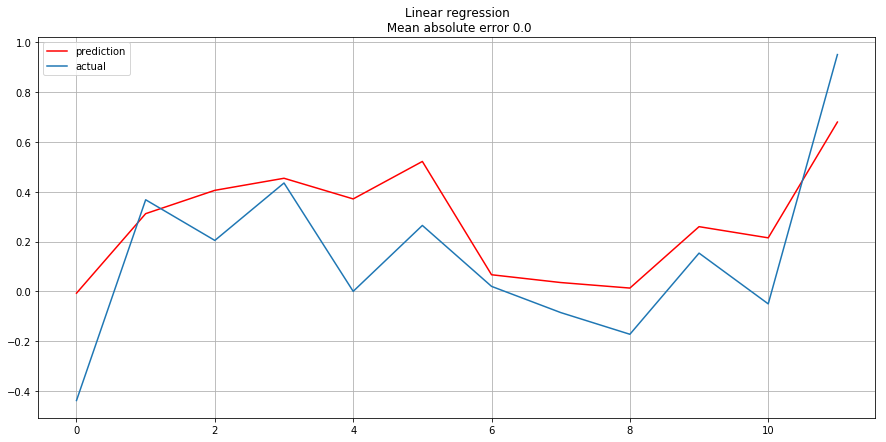

In [260]:
lr3, prediction3 = predict(X_train, X_test, y_train, y_test)

- С учётом значения в прошлом году:

In [299]:
X_train, X_test, y_train, y_test = prepareData(normalizeData(addHeuristics(df_m, previous_year=True, previous_month=True)), target_col='delta', test_index=-12)

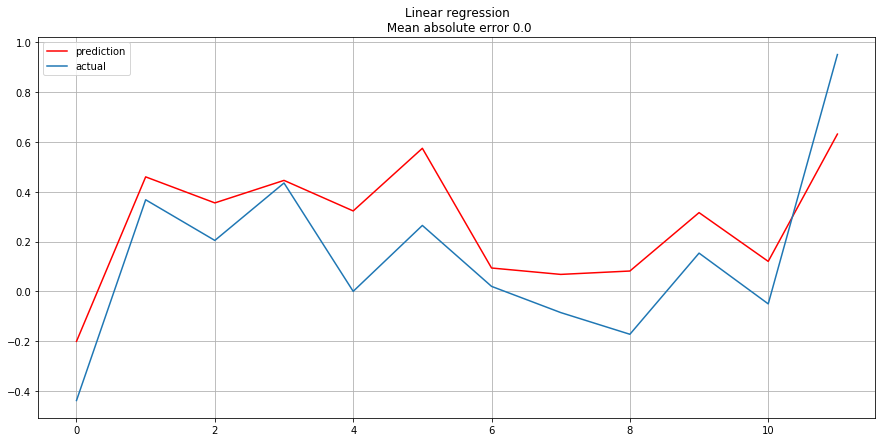

In [300]:
lr4, prediction4 = predict(X_train, X_test, y_train, y_test)

Видим, что несмотря на потерю 13 строк наблюдений из 84, добавление новых признаков положительно влияет на поведение модели.

In [321]:
df_t = addHeuristics(df_m, previous_year=True, previous_month=True)
df_t = df_t.drop(['delta'],axis=1)
df_reduced = reduce(df_t, 11)
del(df_t)
X_train = df_reduced[:-12]
X_test = df_reduced[-12:]
y_train = df_n['delta'][13:-12]
y_test = df_n['delta'][-12:]

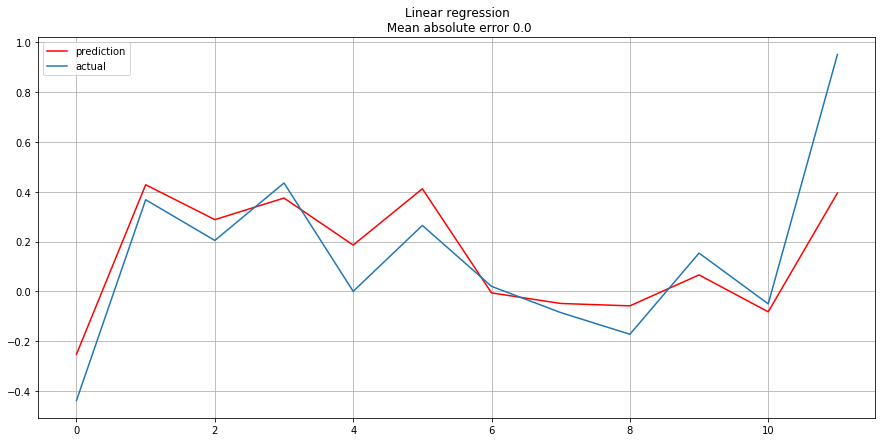

In [322]:
lr5, prediction5 = predict(X_train, X_test, y_train, y_test)

### Conclusion

Вывод: выбранная модель линейной регрессии оказалась вполне применима в целях прогнозирования прироста/убывания объёма рублёвых депозитов. Для повышения точности результатов можно:
- повысить число наблюдений, возможно, учесть зарубежный опыт.
- добавить новые признаки, не предоставленные заказчиком: например, можно предположить, что объём вкладов зависит от числа банков, работающих с физическими лицами. Такие данные, с разбивкой числа банков по их капиталу, предоставляет ЦБ. Например, нами не было изучено, как влияет поведение целевой величины при ликвидации банков, при действии АСВ и проч. Также не были учтены демографические данные и действие внешнеполитических факторов.
- использовать более сложные, возможно, не столь понятные/интерпретируемые модели.